<a href="https://colab.research.google.com/github/tjdux/basic_of_ml/blob/main/23_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM 구조
- Long Short-Term Memory: 단기 기억을 오래 기억하기 위해 고안
- 입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는 구조를 여러 개 가지고 있음
- 계산 결과는 다음 타임스텝에 재사용됨
- 은닉 상태를 만드는 방법
  - 1️⃣ 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수 (sigmoid)를 통과시켜 다음 은닉 상태를 만듦
  - 2️⃣ tanh 활성화 함수를 통과한 어떤 값(셀 상태)과 곱해져 은닉 상태를 만듦
  - LSTM은 순환되는 상태가 은닉 상태, 셀 상태 2개
![img](https://velog.velcdn.com/images/2kimjh/post/dd25b8e3-aac6-41a4-8a87-bca5039535d6/image.png)
- 셀 상태 (cell state)
  - 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값 (c)
  ![img](https://velog.velcdn.com/images/2kimjh/post/98c9dedd-8c84-46cb-b382-d1de70113615/image.png)
  - 1️⃣ 입력과 은닉 상태를 또 다른 가중치 $w_f$에 곱한 다음 시그모이드 함수를 통과
  - 2️⃣ 이전 타임스텝의 셀 상태와 곱하여 새로운 셀 상태 생성
  - 3️⃣새로운 셀 상태가 오른쪽 tanh 함수를 통과하여 새로운 은닉 상태를 만드는 데 기여
- LSTM은 마치 작은 셀을 여러 개 포함하고 있는 큰 셀과 같음
- ⭐ **입력과 은닉 상태에 곱해지는 가중치 $w_o$와 $w_f$는 다름**
- LSTM은 총 4개의 셀이 존재
  ![img](https://velog.velcdn.com/images/2kimjh/post/67117c2b-a668-4034-91fb-f4c980fa3acc/image.png)
  - 입력과 은닉 상태를 각기 다른 가중치에 곱한 다음, 하나는 시그모이드 함수를 통과시키고 다른 하나는 tanh 함수를 통과 시킴 ➡️ 두 결과를 곱한 후 이전 셀 상태와 더함
  - 삭제 게이트: 셀 상태에 있는 정보를 제거하는 역할
  - 입력 게이트: 새로운 정보를 셀 상태에 추가
  - 출력 게이트: 이 셀 상태가 다음 은닉 상태로 출력

## LSTM 신경망 훈련하기

In [1]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
from tensorflow import train
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [10]:
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.build(input_shape=(None, 100))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

- LSTM 셀 파라미터 개수: $((16 * 8) + (8 * 8) + 8) * 4 (4개의 셀) = 800$

In [12]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-lstm-model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data = (val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5293 - loss: 0.6926

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5295 - loss: 0.6926 - val_accuracy: 0.5722 - val_loss: 0.6912
Epoch 2/100
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5831 - loss: 0.6903

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5833 - loss: 0.6902 - val_accuracy: 0.6222 - val_loss: 0.6870
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6347 - loss: 0.6847

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6347 - loss: 0.6847 - val_accuracy: 0.6540 - val_loss: 0.6765
Epoch 4/100
307/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6629 - loss: 0.6693

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6631 - loss: 0.6691 - val_accuracy: 0.6990 - val_loss: 0.6364
Epoch 5/100
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7197 - loss: 0.6089

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7197 - loss: 0.6086 - val_accuracy: 0.7272 - val_loss: 0.5682
Epoch 6/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7409 - loss: 0.5511

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7409 - loss: 0.5511 - val_accuracy: 0.7430 - val_loss: 0.5429
Epoch 7/100
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7551 - loss: 0.5297

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7551 - loss: 0.5297 - val_accuracy: 0.7618 - val_loss: 0.5240
Epoch 8/100
307/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7727 - loss: 0.5096

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7727 - loss: 0.5096 - val_accuracy: 0.7658 - val_loss: 0.5079
Epoch 9/100
308/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7739 - loss: 0.4970

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7740 - loss: 0.4969 - val_accuracy: 0.7698 - val_loss: 0.5000
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7815 - loss: 0.4846

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7816 - loss: 0.4846 - val_accuracy: 0.7756 - val_loss: 0.4862
Epoch 11/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7913 - loss: 0.4725

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7913 - loss: 0.4724 - val_accuracy: 0.7816 - val_loss: 0.4780
Epoch 12/100
308/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7933 - loss: 0.4656

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7934 - loss: 0.4655 - val_accuracy: 0.7904 - val_loss: 0.4682
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7977 - loss: 0.4566

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7977 - loss: 0.4566 - val_accuracy: 0.7878 - val_loss: 0.4635
Epoch 14/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8003 - loss: 0.4488

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8003 - loss: 0.4488 - val_accuracy: 0.7910 - val_loss: 0.4561
Epoch 15/100
308/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8074 - loss: 0.4374

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8073 - loss: 0.4375 - val_accuracy: 0.7906 - val_loss: 0.4525
Epoch 16/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8074 - loss: 0.4358

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8074 - loss: 0.4358 - val_accuracy: 0.7954 - val_loss: 0.4487
Epoch 17/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8071 - loss: 0.4372

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8071 - loss: 0.4372 - val_accuracy: 0.7984 - val_loss: 0.4472
Epoch 18/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8130 - loss: 0.4257

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8129 - loss: 0.4257 - val_accuracy: 0.7924 - val_loss: 0.4455
Epoch 19/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8091 - loss: 0.4297 - val_accuracy: 0.7890 - val_loss: 0.4470
Epoch 20/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8087 - loss: 0.4261

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8087 - loss: 0.4261 - val_accuracy: 0.7946 - val_loss: 0.4412
Epoch 21/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8137 - loss: 0.4180

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8137 - loss: 0.4180 - val_accuracy: 0.7966 - val_loss: 0.4394
Epoch 22/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8143 - loss: 0.4158

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8143 - loss: 0.4159 - val_accuracy: 0.7970 - val_loss: 0.4384
Epoch 23/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8092 - loss: 0.4209 - val_accuracy: 0.7990 - val_loss: 0.4433
Epoch 24/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8107 - loss: 0.4252 - val_accuracy: 0.7894 - val_loss: 0.4426
Epoch 25/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8148 - loss: 0.4150

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8148 - loss: 0.4150 - val_accuracy: 0.7976 - val_loss: 0.4366
Epoch 26/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8158 - loss: 0.4102 - val_accuracy: 0.7922 - val_loss: 0.4377
Epoch 27/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8106 - loss: 0.4189 - val_accuracy: 0.8010 - val_loss: 0.4388
Epoch 28/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8167 - loss: 0.4122 - val_accuracy: 0.7938 - val_loss: 0.4501


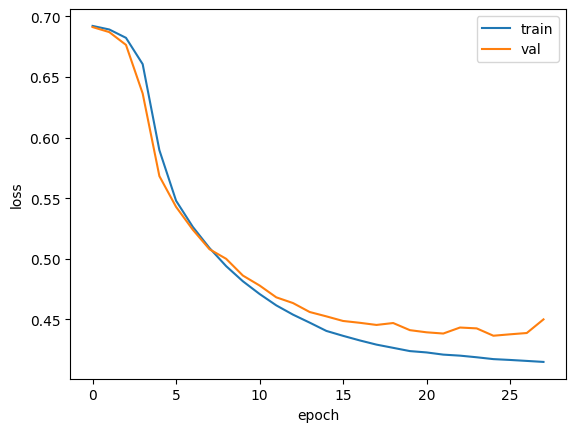

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

- 👉 기존 순환층보다 LSTM이 과대적합을 억제하면서 훈련을 잘 수행

## 순환층에 드롭아웃 적용하기
- `SimpleRNN`, `LSTM` 모두 `dropout`, `recurrent_dropout` 매개변수 제공
  - `dropout`: 셀의 입력에 드롭아웃을 적용
  - `recurrent_dropout`: 순환되는 은닉 상태에 드롭아웃 적용 (적용 시 GPU 사용 불가)

In [14]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-dropout-model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data = (val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5218 - loss: 0.6927

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5219 - loss: 0.6927 - val_accuracy: 0.5796 - val_loss: 0.6919
Epoch 2/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5765 - loss: 0.6914

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5766 - loss: 0.6914 - val_accuracy: 0.6122 - val_loss: 0.6900
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6108 - loss: 0.6891

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6108 - loss: 0.6891 - val_accuracy: 0.6346 - val_loss: 0.6860
Epoch 4/100
308/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6278 - loss: 0.6840

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6280 - loss: 0.6840 - val_accuracy: 0.6428 - val_loss: 0.6745
Epoch 5/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6565 - loss: 0.6667

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6566 - loss: 0.6666 - val_accuracy: 0.7126 - val_loss: 0.6255
Epoch 6/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7060 - loss: 0.6209

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7060 - loss: 0.6208 - val_accuracy: 0.7220 - val_loss: 0.5951
Epoch 7/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7240 - loss: 0.5943

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7240 - loss: 0.5943 - val_accuracy: 0.7294 - val_loss: 0.5768
Epoch 8/100
307/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7346 - loss: 0.5746

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7348 - loss: 0.5745 - val_accuracy: 0.7376 - val_loss: 0.5578
Epoch 9/100
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7431 - loss: 0.5565

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7433 - loss: 0.5563 - val_accuracy: 0.7516 - val_loss: 0.5404
Epoch 10/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7605 - loss: 0.5309

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7605 - loss: 0.5309 - val_accuracy: 0.7652 - val_loss: 0.5249
Epoch 11/100
308/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7661 - loss: 0.5182

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7661 - loss: 0.5181 - val_accuracy: 0.7662 - val_loss: 0.5119
Epoch 12/100
307/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7723 - loss: 0.5059

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7723 - loss: 0.5058 - val_accuracy: 0.7760 - val_loss: 0.4992
Epoch 13/100
307/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7830 - loss: 0.4878

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7830 - loss: 0.4878 - val_accuracy: 0.7776 - val_loss: 0.4898
Epoch 14/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7893 - loss: 0.4793

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7893 - loss: 0.4793 - val_accuracy: 0.7828 - val_loss: 0.4793
Epoch 15/100
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7939 - loss: 0.4688

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7938 - loss: 0.4688 - val_accuracy: 0.7844 - val_loss: 0.4737
Epoch 16/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7914 - loss: 0.4648

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7915 - loss: 0.4648 - val_accuracy: 0.7874 - val_loss: 0.4662
Epoch 17/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7978 - loss: 0.4542

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7978 - loss: 0.4542 - val_accuracy: 0.7916 - val_loss: 0.4605
Epoch 18/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8032 - loss: 0.4466

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8032 - loss: 0.4466 - val_accuracy: 0.7906 - val_loss: 0.4571
Epoch 19/100
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7977 - loss: 0.4484

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7977 - loss: 0.4483 - val_accuracy: 0.7932 - val_loss: 0.4507
Epoch 20/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8060 - loss: 0.4379

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8060 - loss: 0.4379 - val_accuracy: 0.7938 - val_loss: 0.4473
Epoch 21/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8077 - loss: 0.4304

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8077 - loss: 0.4305 - val_accuracy: 0.7940 - val_loss: 0.4470
Epoch 22/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8102 - loss: 0.4281

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8101 - loss: 0.4282 - val_accuracy: 0.7988 - val_loss: 0.4431
Epoch 23/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8064 - loss: 0.4333

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8064 - loss: 0.4333 - val_accuracy: 0.7978 - val_loss: 0.4406
Epoch 24/100
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8085 - loss: 0.4270

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8085 - loss: 0.4270 - val_accuracy: 0.7978 - val_loss: 0.4389
Epoch 25/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8104 - loss: 0.4261 - val_accuracy: 0.7938 - val_loss: 0.4406
Epoch 26/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8074 - loss: 0.4292

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8074 - loss: 0.4291 - val_accuracy: 0.7972 - val_loss: 0.4359
Epoch 27/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8122 - loss: 0.4215 - val_accuracy: 0.7932 - val_loss: 0.4390
Epoch 28/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8098 - loss: 0.4247 - val_accuracy: 0.8002 - val_loss: 0.4370
Epoch 29/100
308/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8111 - loss: 0.4233

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8110 - loss: 0.4233 - val_accuracy: 0.7980 - val_loss: 0.4339
Epoch 30/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8103 - loss: 0.4208 - val_accuracy: 0.7934 - val_loss: 0.4381
Epoch 31/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8086 - loss: 0.4211 - val_accuracy: 0.7948 - val_loss: 0.4484
Epoch 32/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8103 - loss: 0.4217

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8103 - loss: 0.4217 - val_accuracy: 0.8020 - val_loss: 0.4336
Epoch 33/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8118 - loss: 0.4155 - val_accuracy: 0.8032 - val_loss: 0.4346
Epoch 34/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8103 - loss: 0.4159

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8103 - loss: 0.4159 - val_accuracy: 0.8014 - val_loss: 0.4309
Epoch 35/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8146 - loss: 0.4176 - val_accuracy: 0.7972 - val_loss: 0.4325
Epoch 36/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8144 - loss: 0.4135

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8144 - loss: 0.4135 - val_accuracy: 0.7996 - val_loss: 0.4308
Epoch 37/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8161 - loss: 0.4111

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8160 - loss: 0.4111 - val_accuracy: 0.7982 - val_loss: 0.4306
Epoch 38/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8087 - loss: 0.4181 - val_accuracy: 0.7972 - val_loss: 0.4317
Epoch 39/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8167 - loss: 0.4093

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8167 - loss: 0.4094 - val_accuracy: 0.8016 - val_loss: 0.4286
Epoch 40/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8166 - loss: 0.4101 - val_accuracy: 0.8032 - val_loss: 0.4298
Epoch 41/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8142 - loss: 0.4094 - val_accuracy: 0.8032 - val_loss: 0.4297
Epoch 42/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8130 - loss: 0.4120 - val_accuracy: 0.8038 - val_loss: 0.4310


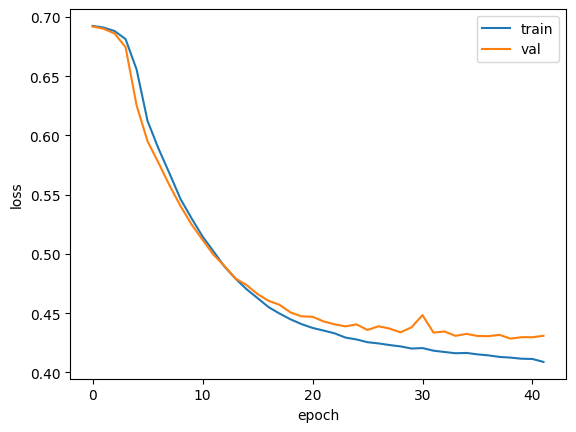

In [16]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

- 👉 훈련 손실과 검증 손실 간의 차이가 좁혀짐

## 2개의 층을 연결하기
- 앞쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력
- 마지막 순환층만 마지막 타임스텝의 은닉 상태를 출력
- `return_sequences=True`: 모든 타임스텝에 대한 은닉 상태 출력

In [26]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))
model3.build(input_shape=(None, 100))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
model3.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 100, 8)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

- 👉 첫 번째 LSTM 층: 모든 타임스텝(100개)의 은닉 상태를 출력

In [28]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-2rnn-model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data = (val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5021 - loss: 0.6931

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5021 - loss: 0.6931 - val_accuracy: 0.4874 - val_loss: 0.6932
Epoch 2/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5069 - loss: 0.6930

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5069 - loss: 0.6930 - val_accuracy: 0.4902 - val_loss: 0.6931
Epoch 3/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5147 - loss: 0.6929

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5148 - loss: 0.6929 - val_accuracy: 0.5264 - val_loss: 0.6927
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5450 - loss: 0.6925

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5450 - loss: 0.6925 - val_accuracy: 0.5842 - val_loss: 0.6919
Epoch 5/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5761 - loss: 0.6913

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5761 - loss: 0.6913 - val_accuracy: 0.6142 - val_loss: 0.6889
Epoch 6/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6030 - loss: 0.6866

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6032 - loss: 0.6865 - val_accuracy: 0.6608 - val_loss: 0.6677
Epoch 7/100
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6437 - loss: 0.6580

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6440 - loss: 0.6578 - val_accuracy: 0.6996 - val_loss: 0.6053
Epoch 8/100
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6892 - loss: 0.6068

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6894 - loss: 0.6066 - val_accuracy: 0.7244 - val_loss: 0.5652
Epoch 9/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7234 - loss: 0.5655

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7234 - loss: 0.5655 - val_accuracy: 0.7498 - val_loss: 0.5304
Epoch 10/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7550 - loss: 0.5297

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7550 - loss: 0.5297 - val_accuracy: 0.7556 - val_loss: 0.5111
Epoch 11/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7573 - loss: 0.5122

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7574 - loss: 0.5121 - val_accuracy: 0.7686 - val_loss: 0.4916
Epoch 12/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7756 - loss: 0.4950

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7756 - loss: 0.4949 - val_accuracy: 0.7798 - val_loss: 0.4809
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7888 - loss: 0.4731 - val_accuracy: 0.7646 - val_loss: 0.4900
Epoch 14/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7841 - loss: 0.4783

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7841 - loss: 0.4783 - val_accuracy: 0.7836 - val_loss: 0.4688
Epoch 15/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7887 - loss: 0.4691

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7887 - loss: 0.4691 - val_accuracy: 0.7870 - val_loss: 0.4628
Epoch 16/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7865 - loss: 0.4656

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7865 - loss: 0.4656 - val_accuracy: 0.7884 - val_loss: 0.4606
Epoch 17/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7940 - loss: 0.4576

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7940 - loss: 0.4576 - val_accuracy: 0.7864 - val_loss: 0.4570
Epoch 18/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7948 - loss: 0.4555

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7948 - loss: 0.4555 - val_accuracy: 0.7860 - val_loss: 0.4561
Epoch 19/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7959 - loss: 0.4555

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7959 - loss: 0.4555 - val_accuracy: 0.7894 - val_loss: 0.4523
Epoch 20/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7994 - loss: 0.4518 - val_accuracy: 0.7864 - val_loss: 0.4526
Epoch 21/100
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7970 - loss: 0.4508

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7970 - loss: 0.4507 - val_accuracy: 0.7914 - val_loss: 0.4498
Epoch 22/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7982 - loss: 0.4494

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7982 - loss: 0.4494 - val_accuracy: 0.7934 - val_loss: 0.4465
Epoch 23/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7973 - loss: 0.4483 - val_accuracy: 0.7916 - val_loss: 0.4517
Epoch 24/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8070 - loss: 0.4376

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8070 - loss: 0.4376 - val_accuracy: 0.7908 - val_loss: 0.4450
Epoch 25/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8077 - loss: 0.4353 - val_accuracy: 0.7860 - val_loss: 0.4508
Epoch 26/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8077 - loss: 0.4330 - val_accuracy: 0.7820 - val_loss: 0.4546
Epoch 27/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8030 - loss: 0.4436 - val_accuracy: 0.7944 - val_loss: 0.4467


- 👉 일반적으로 순환층을 쌓으면 성능이 높아짐

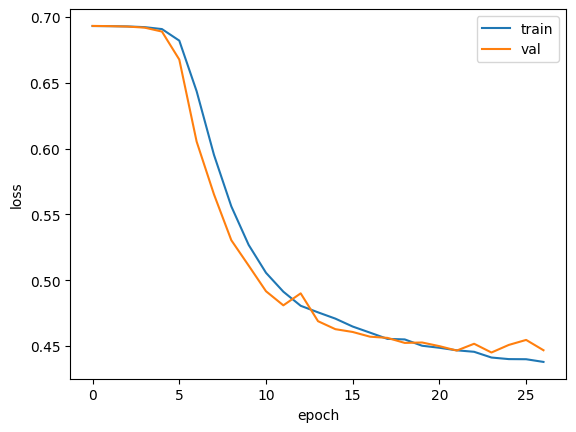

In [29]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

- 👉 과대적합을 제어하면서 손실을 최대한으로 낮춤

In [35]:
test_seq = pad_sequences(test_input, maxlen=100)
rnn_model = keras.models.load_model("best-2rnn-model.h5")
rnn_model.evaluate(test_seq, test_target)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7945 - loss: 0.4423


[0.44346487522125244, 0.7936400175094604]

## GRU 구조
- Gated Recurrent Unit: LSTM의 간소화 버전
- 은닉 상태 하나만 포함 (셀 상태를 계산하지 않음)
- 계산량이 적지만 LSTM 못지않은 좋은 성능
![img](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FupyQr%2FbtsA25lmJla%2FAAAAAAAAAAAAAAAAAAAAAIccIfkWYln6mB2qnCtXmoCNoGVMehNiC1Xs7Iv3vmhC%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1772290799%26allow_ip%3D%26allow_referer%3D%26signature%3DkoyrzyaEQd2xcssjcLCK3GphEGo%253D)
- 왼쪽 그림: GRU 구조
  - 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀 3개
  - 2개는 시그모이드 활성화 함수, 1개는 tanh 활성화 함수 사용
  - $w_z$를 사용하는 셀의 출력이 은닉 상태에 바로 곱해져 삭제 게이트 역할을 수행
  - 이와 똑같은 출력을 1에서 뺀 다음 가장 오른 쪽 $w_g$를 사용하는 셀의 출력에 곱함 (입력되는 정보를 제어하는 역할)
  - 가운데 $w_r$을 사용하는 셀에서 출력된 값은 $w_g$셀이 사용할 은닉 상태의 정보를 제어
- 오른쪽 그림: GRU 셀의 초기 버전
  - G: 은닉 상태가 먼저 가중치와 곱해진 다음 가운데 셀의 출력과 곱해짐
  - 왼쪽의 $w_g$이 $w_X$와 $w_h$로 나누어짐

## GRU 신경망 훈련하기

In [31]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))
model4.build(input_shape=(None, 100))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [32]:
model4.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

- 은닉 상태에 곱해지는 가중치 외에 절편이 별도로 필요 (오른쪽 그림) (3 * 8)
- 👉 GRU 층의 파라미터 개수: $((16 \times 8) + (8 \times 8) + 8)\times3 + (3 \times 8) = 624$

In [33]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-gru-model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data = (val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
306/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5212 - loss: 0.6927

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5216 - loss: 0.6927 - val_accuracy: 0.5542 - val_loss: 0.6917
Epoch 2/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5621 - loss: 0.6911

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5622 - loss: 0.6911 - val_accuracy: 0.5740 - val_loss: 0.6898
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5846 - loss: 0.6890

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5846 - loss: 0.6890 - val_accuracy: 0.5914 - val_loss: 0.6870
Epoch 4/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6032 - loss: 0.6855

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6033 - loss: 0.6855 - val_accuracy: 0.6044 - val_loss: 0.6828
Epoch 5/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6109 - loss: 0.6798

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6109 - loss: 0.6798 - val_accuracy: 0.6132 - val_loss: 0.6759
Epoch 6/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6264 - loss: 0.6719

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6264 - loss: 0.6719 - val_accuracy: 0.6280 - val_loss: 0.6657
Epoch 7/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6470 - loss: 0.6595

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6470 - loss: 0.6594 - val_accuracy: 0.6458 - val_loss: 0.6476
Epoch 8/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6671 - loss: 0.6373

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6671 - loss: 0.6373 - val_accuracy: 0.6792 - val_loss: 0.6150
Epoch 9/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6998 - loss: 0.5928

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6999 - loss: 0.5926 - val_accuracy: 0.7350 - val_loss: 0.5387
Epoch 10/100
307/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7452 - loss: 0.5242

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7454 - loss: 0.5240 - val_accuracy: 0.7568 - val_loss: 0.5068
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7643 - loss: 0.4934

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7643 - loss: 0.4934 - val_accuracy: 0.7678 - val_loss: 0.4911
Epoch 12/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7793 - loss: 0.4764

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7793 - loss: 0.4764 - val_accuracy: 0.7764 - val_loss: 0.4799
Epoch 13/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7795 - loss: 0.4728

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7796 - loss: 0.4727 - val_accuracy: 0.7744 - val_loss: 0.4767
Epoch 14/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7914 - loss: 0.4562

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7914 - loss: 0.4562 - val_accuracy: 0.7812 - val_loss: 0.4678
Epoch 15/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8018 - loss: 0.4459 - val_accuracy: 0.7806 - val_loss: 0.4683
Epoch 16/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7966 - loss: 0.4469 - val_accuracy: 0.7764 - val_loss: 0.4788
Epoch 17/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8039 - loss: 0.4399

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8039 - loss: 0.4399 - val_accuracy: 0.7786 - val_loss: 0.4651
Epoch 18/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8045 - loss: 0.4406

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8045 - loss: 0.4406 - val_accuracy: 0.7916 - val_loss: 0.4520
Epoch 19/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8104 - loss: 0.4306 - val_accuracy: 0.7854 - val_loss: 0.4611
Epoch 20/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8119 - loss: 0.4258 - val_accuracy: 0.7846 - val_loss: 0.4610
Epoch 21/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8100 - loss: 0.4274 - val_accuracy: 0.7860 - val_loss: 0.4570


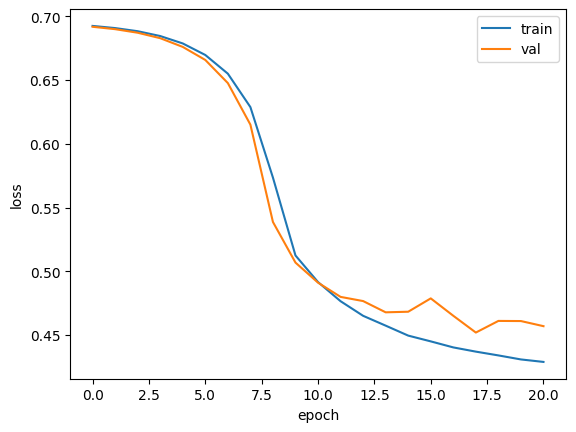

In [34]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()